# Application des réseaux de neurones à de la classification multi-classe supervisée
## Chargement des librairies
Tout d'abord nous allons charger les librairies standards.

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Neural as Neur

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Position du problème
Nous aurons $n$ données d'entrées qui seront des vecteurs de $\mathbb{R}^2$, ainsi $X$ est une matrice $(2,n)$. En sortie, nous avons $n$ vecteurs de taille $3$ qui sont égaux à $[1,0,0]$ ou à $[0,1,0]$ ou à $[0,0,1]$, par convention les vecteurs de type $[1,0,0]$ seront des vecteurs de la `classe rouge`, ceux de   $[0,1,0]$ de la `classe verte` et ceux de $[0,0,1]$ de la `classe bleue`. Les vecteurs $X$ de taille $(2,n)$ et $Y$ de taille $(3,n)$ sont construits dans la fonction suivante :

In [19]:
def Spiral(n0):
    n = n0*3 # nombre total de points
    x = np.zeros((2,n))
    y = np.zeros((3,n))
    for j in np.arange(0,3):
        I = np.arange(n0*(j-1),n0*j) # indices dans lesquels on range les classe
        r = np.linspace(0.0,1,n0) # radius
        t = np.linspace(j*4,(j+1)*4,n0) + np.random.randn(1,n0)*0.2 # angle
        x[0,I] = r*np.sin(t)
        x[1,I] = r*np.cos(t)
        y[j,I] = 1.
    return x,y
n=300
x,y = Spiral(100)
x_test, y_tetst = Spiral(100)

Dans la fonction ci-dessous, on affiche les données, noter l'usage de la fonction `color` qui permet de colorier un point en couleur RGB.

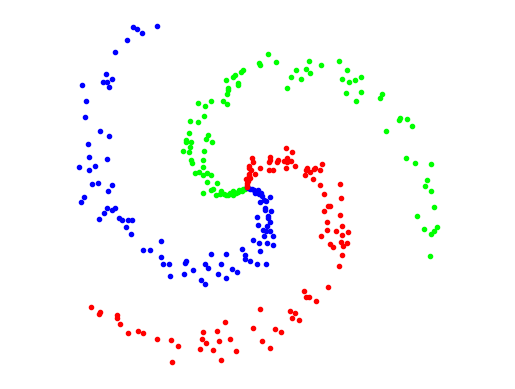

In [20]:
for i in np.arange(n):
    plt.plot(x[0,i], x[1,i], '.', color=y[:,i])
plt.axis('equal')
plt.axis('off');
Z = np.random.randn(3,2)

# Régression logistique multi-classe
Le réseau de neurone va nous rendre des vecteurs de $z$ de $\mathbb{R}^3$, ce qui n'est pas interprétable pour nous, nous voulons plutôt des vecteurs $\tilde y$  dont toutes les coordonnées sont positives et dont la somme vaut $1$, ainsi on interprétera les vecteurs de sorties comme la probablité d'être dans chaque classe. Ainsi si $\tilde y$ vaut $[0.5,0.3,0.2]$, on interprétera ce vecteur comme étant un vecteur qui a une probabilité $0.5$ d'être dans la classe `rouge`, une probabilité $0.3$ dans la classe `verte` et $0.2$ dans la classe `bleue`. Pour la représentation, $\tilde y$ sera colorié dans la couleur RGB $[0.5,0.3,0.2]$.

La transformation usuelle est dite transformation `ilogit` (lire "inverse de la logit") qui correspond à faire
$$ z=\begin{pmatrix} z_1 \\ z_2 \\ z_3 \end{pmatrix} \Rightarrow \tilde y =\frac{1}{\sum_{i=1}^3 e^{z_i}}\begin{pmatrix}e^{z_1}\\ e^{z_2} \\ e^{z_3}\end{pmatrix}$$
Le problème est que le réseau de neurone travaille sur toutes les $n$ données en même temps et que $z$ sera une matrice de taille $(3,n)$. Il faut implémenter l'opération précédente sur toutes les colonnes de $z$ en même temps. On appelera cette transformation `ilogit`. On pourra penser à utiliser la fonction `a.sum(axis=0)` qui prend un tableau `a` et qui fait la somme sur chacune des premières coordonnées (les colonnes si `a` est une matrice).

In [21]:
def ilogit(z) :
    x = np.exp(z)
    return x/x.sum(axis=0)

np.random.seed(42)
z=np.random.randn(3,2)# ici on a 2 données
print('#### : z')
print(z)
ytilde=ilogit(z)
print('#### : y')
print(ytilde)
# vous devez obtenir
##### : z
#[[ 0.49671415 -0.1382643 ]
# [ 0.64768854  1.52302986]
# [-0.23415337 -0.23413696]]
##### : y
#[[ 0.37814933  0.13937862]
# [ 0.43977514  0.73398479]
# [ 0.18207554  0.12663659]]

#### : z
[[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]]
#### : y
[[0.37814933 0.13937862]
 [0.43977514 0.73398479]
 [0.18207554 0.12663659]]


# Fonction perte
On implémente maintenant la fonction coût (la fonction perte). La fonction coût associée au `ilogit` est usuellement la fonction `logistique` (ou `divergence de Kullback-Leibler`). Si  $\tilde y$ est un vecteur de taille $3$ dont les coordonnées sont positives et somment à $1$, si $y$ est un vecteur qui ne prend que comme valeurs ($[1,0,0]$, $[0,1,0]$,$[0,0,1]$), on peut estimer la différence entre $\tilde y$ et $y$ (les vraies sorties) par :
$$d_{KL}(y,\tilde y)= -\sum_{i=1}^3 y_i \ln \tilde y_i $$
Vérifiez que cette fonction est convexe en $\tilde y$, qu'elle est toujours positive pour les vecteurs $\tilde y$ considérés et qu'elle s'annule uniquement si $\tilde y_i =y_i$ 


En se souvenant que $\tilde y= ilogit(z)$, montrer que cette fonction de "distance" entre $y$ et $\tilde y$ s'écrit en fonction de $z$ comme
$$d_{KL}(y,\textrm{ilogit}(z))=d(y,z) \text{ avec } d(y,z)=ln(\sum_{i=1}^3 e^{z_i})−\langle z,y\rangle$$
On va utiliser cette "distance" $d$ entre $y$ et $z$.
Montrer que le gradient par rapport à $z$ de cette "distance" est donné par
$$\nabla_z d(y,z)=\tilde y-y$$
C'est pour cela que cette "distance" est très utilisée, son gradient s'annule exactement si $\tilde y=y$ !! 

# Implémentation de la couche Ilogit_and_KL
Nous allons maintenant programmer la fonction $d_{KL}$ et son gradient par rapport à $z$ dans les fonctions `loss` et  `deriv_loss`. Attention $y$ et $\tilde y$ ne sont pas des vecteurs de taille $3$ mais bien des matrices $(3,n)$ avec $n$ le nombre de données. Dans ce cas la fonction `loss` devra calculer
$$ \textrm{loss}(y,\tilde y) =\sum_{p=1}^n d_{KL}(y_{\bullet,p},\tilde y_{\bullet,p}),$$
où $y_{\bullet,p}$ est la p-eme colonne de la matrice $y$
et le gradient est simplement donné par $\tilde y - y$

In [22]:
np.random.seed(42)
import Neural as Neur
z=np.random.randn(3,2)# ici on a 2 données, c'est la sortie du réseau de neurone
ytilde=ilogit(z) # on applique ilogit pour avoir le calcul de ytilde
y_0=np.array([[1,0,0],[0,1,0]]).T # Voici les données que l'on aimerait avoir
print(y_0)
L=Neur.Ilogit_and_KL(y_0)
print(L.forward(z))
print(L.backward(None))
# Vous devez trouver
#[[1 0]
# [0 1]
# [0 0]]
#1.2817330961
#(None, array([[-0.62185067,  0.13937862],
#       [ 0.43977514, -0.26601521],
#       [ 0.18207554,  0.12663659]]))

[[1 0]
 [0 1]
 [0 0]]
1.2817330961045947
(array([], dtype=float64), array([[-0.62185067,  0.13937862],
       [ 0.43977514, -0.26601521],
       [ 0.18207554,  0.12663659]]))


On peut même faire un test de dérivée numérique en comparant `loss(y_0,ilogit(z+sd))-loss(y_0,ilogit(z))` avec le gradient par rapport à $z$.  

In [23]:
np.random.seed(42)
import Neural as Neur
z=np.random.randn(3,2)# ici on a 2 données, c'est la sortie du réseau de neurone
y_0=np.array([[1,0,0],[0,1,0]]).T # Voici les données que l'on aimerait avoir
L=Neur.Ilogit_and_KL(y_0)
L.forward(z)
a,grad=L.backward(None)

d=np.random.randn(3,2) # direction dans lequel on teste le gradient
derivee=np.dot(grad.flatten(),d.flatten())
for s in [1.e-12,1.e-8,1.e-6,1.e-4,1.e-2] :
    diff=1/s*(L.forward(z+s*d)-L.forward(z))
    print(s,diff/derivee-1.)

1e-12 9.544171819553249e-05
1e-08 5.336250996634817e-09
1e-06 -4.06086180460008e-07
0.0001 -4.059921492682861e-05
0.01 -0.004064699620765055


## Construction des réseaux de Neurone
Nous aurons besoin de 2 réseaux de neurones, le premier `N_a` sera utilisé pour l'apprentissage et le deuxième `N` sera utilisé une fois les données apprises. 
* Pour l'instant le réseau `N` sera composé d'une couche dense $(2,15)$ suivie d'une couche arctangente puis d'une couche dense $(15,3)$ et d'une couche arctangente. Le réseau `N` simule bien une fonction de $\mathbb{R}^2$ dans $\mathbb{R}^3$. Quand on voudra calculer la probabilité de couleur d'un point $X$, on regardera `ilogit(N(X))`
* Le réseau `N_a` est utilisé pour l'apprentissage, ce sera juste le réseau composé de `N` suivi de la couche `Ilogit_and_KL`. Comme les données sont stockées dans les couches, une fois l'apprentissage terminé, on ne se souciera plus de `N_a`. Voici un des avantages de considérer les réseaux de neurones comme des couches. Il existe un autre avantage dans les auto-encodeurs (voir un autre TP).
Créez vos réseaux de Neurones dans la ligne ci-dessous. Pour vérifier vos calculs, un test de dérivée numérique est incorporé.

In [28]:
np.random.seed(42)
import Neural as Neur
N=Neur.Network([Neur.Dense(2,15),Neur.Arctan(),Neur.Dense(15,3),Neur.Arctan()])
N_a=Neur.Network([N,Neur.Ilogit_and_KL(y)])
cost = []

forward_save = N_a.forward(x)
grad_param,grad_donnees=N_a.backward(None)
print(forward_save,'?=? 467.826363584561')

print('################# TEST de dérivée numérique pour les données')
d=np.random.randn(x.shape[0],x.shape[1]) # direction dans lequel on teste le gradient
derivee=np.dot(grad_donnees.flatten(),d.flatten())
for s in [1.e-12,1.e-8,1.e-6,1.e-4,1.e-2] :
    diff=1/s*(N_a.forward(x+s*d)-forward_save)
    print(s,diff/derivee-1.)

print('################# TEST de dérivée numérique pour les paramètres')
theta=N_a.get_params()
d=np.random.randn(theta.shape[0]) # direction dans lequel on teste le gradient
derivee=np.dot(grad_param.flatten(),d.flatten())
for s in [1.e-12,1.e-8,1.e-6,1.e-4,1.e-2] :
    N_a.set_params(theta+s*d)
    diff=1/s*(N_a.forward(x)-forward_save)
    print(s,diff/derivee-1.)


534.333496324214 ?=? 467.826363584561
################# TEST de dérivée numérique pour les données
1e-12 -0.02503920311116281
1e-08 -1.2813129652844424e-06
1e-06 1.0302149835883512e-05
0.0001 0.001030418488166207
0.01 0.10401047959704401
################# TEST de dérivée numérique pour les paramètres
1e-12 -0.009806661192461319
1e-08 -7.913372553902676e-07
1e-06 9.007143097372605e-06
0.0001 0.0009020830581849548
0.01 0.0917987683444188


## Encore une fonction d'affichage des données

Pour pouvoir interpréter le résultat du réseau de Neurone `N`, on va tracer $N.forward(x)$ pour une série de points sur une grille, c'est ce qui est donné par la fonction suivante :

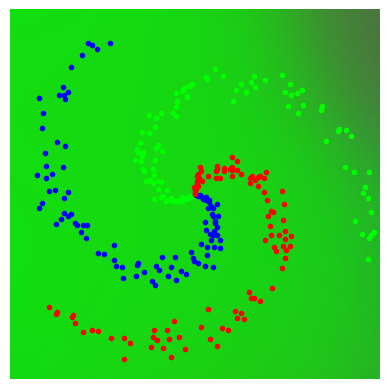

In [29]:
def plot_N(Net) : # ici N est un réseau de neurone
    plt.clf
    q=100 # nombre de points dans chaque direction de la grille
    t = np.linspace(-1,1,q)
    [Yg,Xg] = np.meshgrid(t,t)
    Z = np.vstack([Xg.flatten(), Yg.flatten()])
    V = Net.forward(Z) # evaluation du reseau de neurone
    U = ilogit(V) # transformation ilogit des données
    U = np.reshape(U.transpose(), [q,q,3] ) # reshape de la matrice
    plt.imshow(U.transpose((1, 0, 2)), origin="lower", extent=[-1,1,-1,1]) # plot de la matrice des données
    for i in np.arange(n):
        plt.plot(x[0,i], x[1,i], '.', color=y[:,i]) # plot des vraies données
    plt.axis('off')
plot_N(N)

## Et maintenant place à l'optimisation

On va enfin lancer notre algorithme d'optimisation !!! on va se contenter pour l'instant d'un algo à pas fixe de .01/15. Pour rappel, normalement la variable $x$ contient les données d'entrées et la variable $y$ les données de sortie. 
- On rappelle que les variables du réseau de neurone peuvent être récupérées par la fonction `C=get(N)`.
- Pour évaluer le réseau de neurone, il faut lancer la fonction `N.forward(x)` qui nous donne `X_list`, la liste des valeurs de $x$ au passage de chaque couche du réseau de neurone. La sortie du réseau de neurone est donc le dernier vecteur de `X_list`, c'est-à-dire `Z=X_list[-1]`. 
- On transforme le vecteur `Z` avec la fonction `ilogit`. Notons `tildeY` le résultat de `ilogit(Z)`. La distance entre `tildeY` et les données est `loss(y,tildeY)`. A chaque itération, on rentre cette distance dans un tableau `cost` que l'on affichera à la fin.
- Ensuite on calcule le gradient de la dernière couche par la fonction `grad_loss` puis on le rétropropage par la fonction `N.backward`. On peut ensuite utiliser la fonction `recup_grad` pour transformer cette liste de gradient en grand vecteur. Il suffit ensuite de modifier `C` avec la méthode de gradient à pas fixe et de remettre à jour les variables du réseau de neurone avec ce nouveau `C` en utilisant la fonction `set(N,C)`.
- Toutes les $400$ itérations, on affiche le coût et on dessine le réseau de neurone sur une grille en utilisant la fonction `plot_N` (C'est déjà implémenté).

A vous...


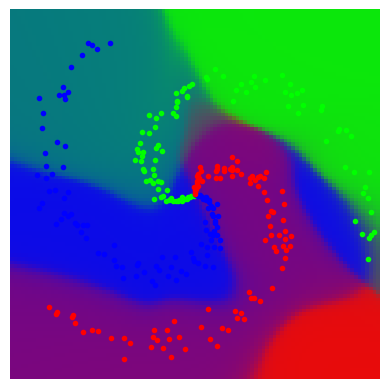

In [31]:
from random import random, randint

step = 0.001/0.02
for i in range(100):
    #step = random() / randint(1,randint(2,30))
    err = N_a.forward(x_test)
    grad_local, grad_entree = N_a.backward(None)
    params = N_a.get_params()
    params = params - step*grad_local
    N_a.set_params(params)
    cost.append(err)

plot_N(N)


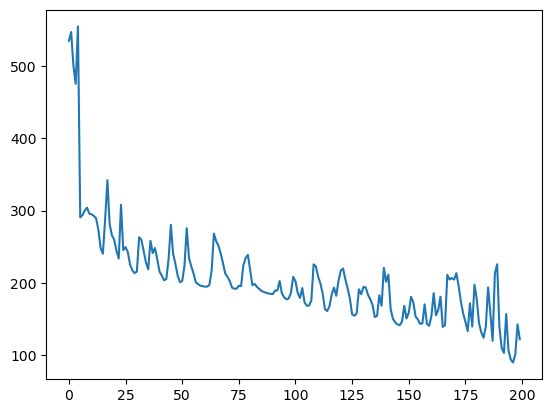

In [32]:
plt.plot(cost)

# Un petit bla bla pour les matheux
Plus tard vous verrez les modèles de classification et notamment les modèles linéaires généralisés. On vous introduira un modèle aléatoire et on vous dira que pour chaque entrée $x_{\bullet,p} \in \mathbb{R}^2$, la sortie $y_{\bullet,p}\in \mathbb{R}^3$ est une variable aléatoire qui prend la valeur $[1,0,0]$ avec la probabilité $\pi_{1,p}$, $[0,1,0]$ avec la probabilité $\pi_{2,p}$ et $[0,0,1]$ avec la probabilité $\pi_{3,p}$.

Donc $\tilde y$ est un matrice de taille $(3,p)$ qui est un "estimateur" de la matrice $\pi$ recherchée. 
Vous verrez que vous n'essayerez pas d'estimer $\pi$ directement mais d'estimer le "logit de $\pi$" c'est-à dire d'estimer pour tout $p$ et tout $i\ne 1$
$$ \ln(\frac {\pi_{i,p} }{\pi_{1,p}})$$
On remarque que si $\pi =$ `ilogit`($\zeta$), alors
$$ \ln(\frac {\pi_{i,p} }{\pi_{1,p}})= \zeta_{i,p} -\zeta_{1,p}.$$
Et on cherche à estimer $\zeta$ . 

Dans les modèles simples (modèle linéaire généralisé), si on note $z$ cet estimateur de $\zeta$, on va chercher à estimer $\zeta$ comme une combinaison linéaire des entrées, c'est-à-dire on cherche une matrice $\hat \theta$ de taille $(3,2)$ telle que
$$ z_{\bullet,p}=\hat \theta x_{\bullet,p}$$
Dans notre cas on a plutôt exprimé $z_{\bullet,p}$ en fonction de $x_{\bullet,p}$ à travers un réseau de neurone et à chercher une approximation non-linéaire.
